In [3]:
import h5py
import sys
import numpy as np
sys.path.append('..')
from modules.configfile import config
import matplotlib.pyplot as plt
from modules.training_helpers import standardize

In [4]:
hdf5_file = h5py.File(config['hdf5_combined'], mode='r')

In [5]:
hg = hdf5_file['combined']

In [6]:
import cPickle as pickle
mean_var = pickle.load(open(config['saveMeanVarCombinedData'], 'rb'))

### Get a 2x4x64x64x64 patch for sample

In [7]:
def showBatch(val):
    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(batch[0,1,:,:,30])
    ax[0].set_title('Patient 1')
    
    ax[1].imshow(batch[1,1,:,:,30])
    ax[1].set_title('Patient 2')
    plt.show()

In [8]:
from modules.vizhelpercode import viewInMayavi

In [9]:
im = hg['training_data'][0:2]
batch = im[:,:,120:184,120:184,80:144]

In [10]:
batch.shape

(2, 4, 64, 64, 64)

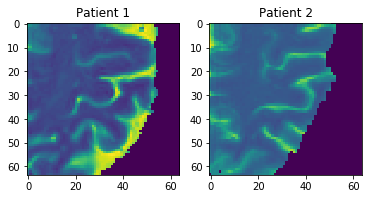

In [11]:
showBatch(batch)

In [16]:
def removeSequence(x_data):
    # randomly remove a sequence from the x_data
    # remember nothing needs to be for the y_data, since that is the ground truth and we want network to learn it.
    # for normalized data with zero mean and unit variance, this is equivalent to imputing the
    # sequence with all zeros.
    # Set all values of a random sequence = 0

    # assuming a batch will be coming with first dimension = batch size. So we permute for all examples in this batch
    assert (len(x_data.shape) > 4), 'Batch size incorrect'
    sequences = [0,1,2,3]

    for curr_eg in range(x_data.shape[0]):
        r = random.randint(0, 10)
        if r > 8:
            print('Going to remove sequence!')
            # how many sequences to remove
            hm = random.randint(0, 3)
            rm_seq = random.sample(sequences, hm)
            print('removing {} sequences'.format(rm_seq))
            for curr_seq in rm_seq:
                x_data[curr_eg,curr_seq,] = 0.0

In [17]:
import random, itertools
def generate_permutation_keys():
    """
    This function returns a set of "keys" that represent the 48 unique rotations &
    reflections of a 3D matrix.
    Each item of the set is a tuple:
    ((rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose)
    As an example, ((0, 1), 0, 1, 0, 1) represents a permutation in which the data is
    rotated 90 degrees around the z-axis, then reversed on the y-axis, and then
    transposed.
    48 unique rotations & reflections:
    https://en.wikipedia.org/wiki/Octahedral_symmetry#The_isometries_of_the_cube
    """
    return set(itertools.product(
        itertools.combinations_with_replacement(range(2), 2), range(2), range(2), range(2), range(2)))


def random_permutation_key():
    """
    Generates and randomly selects a permutation key. See the documentation for the
    "generate_permutation_keys" function.
    """
    return random.choice(list(generate_permutation_keys()))


def permute_data(data, key):
    """
    Permutes the given data according to the specification of the given key. Input data
    must be of shape (n_modalities, x, y, z).
    Input key is a tuple: (rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose)
    As an example, ((0, 1), 0, 1, 0, 1) represents a permutation in which the data is
    rotated 90 degrees around the z-axis, then reversed on the y-axis, and then
    transposed.
    """
    data = np.copy(data)
    (rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose = key

    if rotate_y != 0:
        data = np.rot90(data, rotate_y, axes=(1, 3))
    if rotate_z != 0:
        data = np.rot90(data, rotate_z, axes=(2, 3))
    if flip_x:
        data = data[:, ::-1]
    if flip_y:
        data = data[:, :, ::-1]
    if flip_z:
        data = data[:, :, :, ::-1]
    if transpose:
        for i in range(data.shape[0]):
            data[i] = data[i].T
    return data


def random_permutation_x_y(x_data, y_data):
    """
    Performs random permutation on the data.
    :param x_data: numpy array containing the data. Data must be of shape (n_modalities, x, y, z).
    :param y_data: numpy array containing the data. Data must be of shape (n_modalities, x, y, z).
    :return: the permuted data
    """
    key = random_permutation_key()
    return permute_data(x_data, key), permute_data(y_data, key)


def reverse_permute_data(data, key):
    key = reverse_permutation_key(key)
    data = np.copy(data)
    (rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose = key

    if transpose:
        for i in range(data.shape[0]):
            data[i] = data[i].T
    if flip_z:
        data = data[:, :, :, ::-1]
    if flip_y:
        data = data[:, :, ::-1]
    if flip_x:
        data = data[:, ::-1]
    if rotate_z != 0:
        data = np.rot90(data, rotate_z, axes=(2, 3))
    if rotate_y != 0:
        data = np.rot90(data, rotate_y, axes=(1, 3))
    return data


def reverse_permutation_key(key):
    rotation = tuple([-rotate for rotate in key[0]])
    return rotation, key[1], key[2], key[3], key[4]

In [18]:
rm_batch = removeSequence(batch)

Going to remove sequence!
removing [2] sequences
Going to remove sequence!
removing [2, 3, 0] sequences


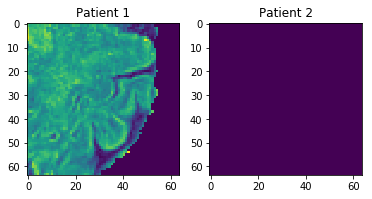

In [21]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(batch[0,3,:,:,30])
ax[0].set_title('Patient 1')

ax[1].imshow(batch[1,0,:,:,30])
ax[1].set_title('Patient 2')
plt.show()

In [57]:
perm_batch, t1 = random_permutation_x_y(batch[0,], batch[0,])

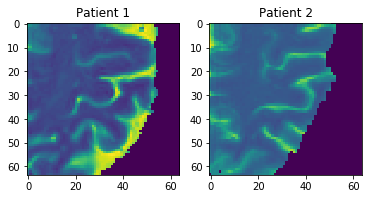

In [58]:
showBatch(batch)

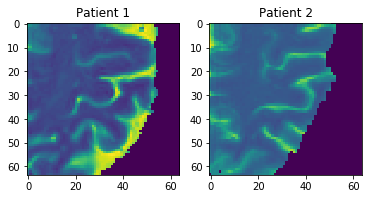

In [60]:
showBatch(t1)